In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
%matplotlib inline

In [3]:
df = pd.read_csv('PJME_hourly.csv')

In [4]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [5]:
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

In [6]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot:title={'center':'Estimated Energy Consumption in Megawatts (MW)'}, xlabel='Datetime'>

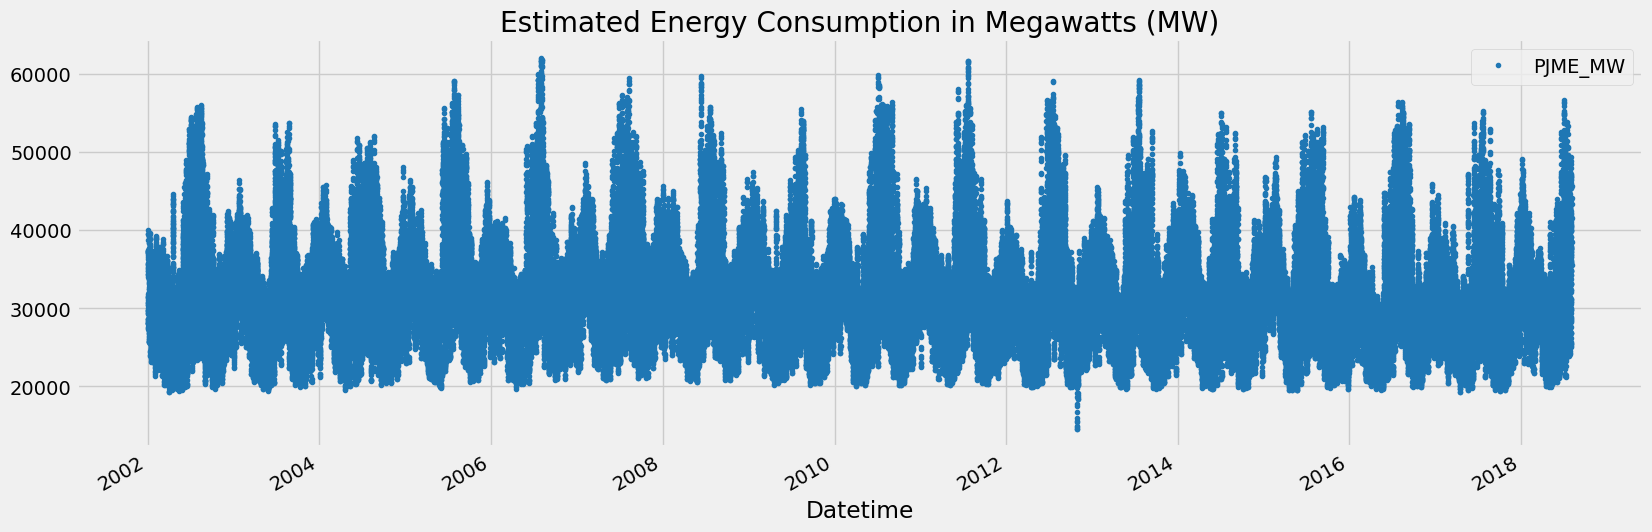

In [7]:
df.plot(style='.', figsize=(18,6), color=color_pal[0], title='Estimated Energy Consumption in Megawatts (MW)')

<AxesSubplot:ylabel='Frequency'>

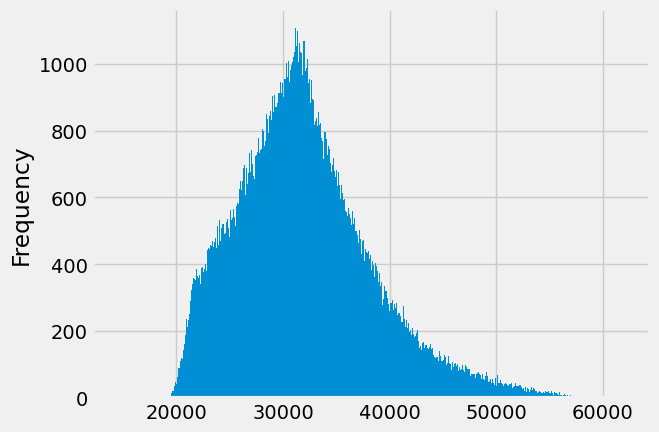

In [8]:
#outlier
df['PJME_MW'].plot(kind='hist', bins=500)

<AxesSubplot:xlabel='Datetime'>

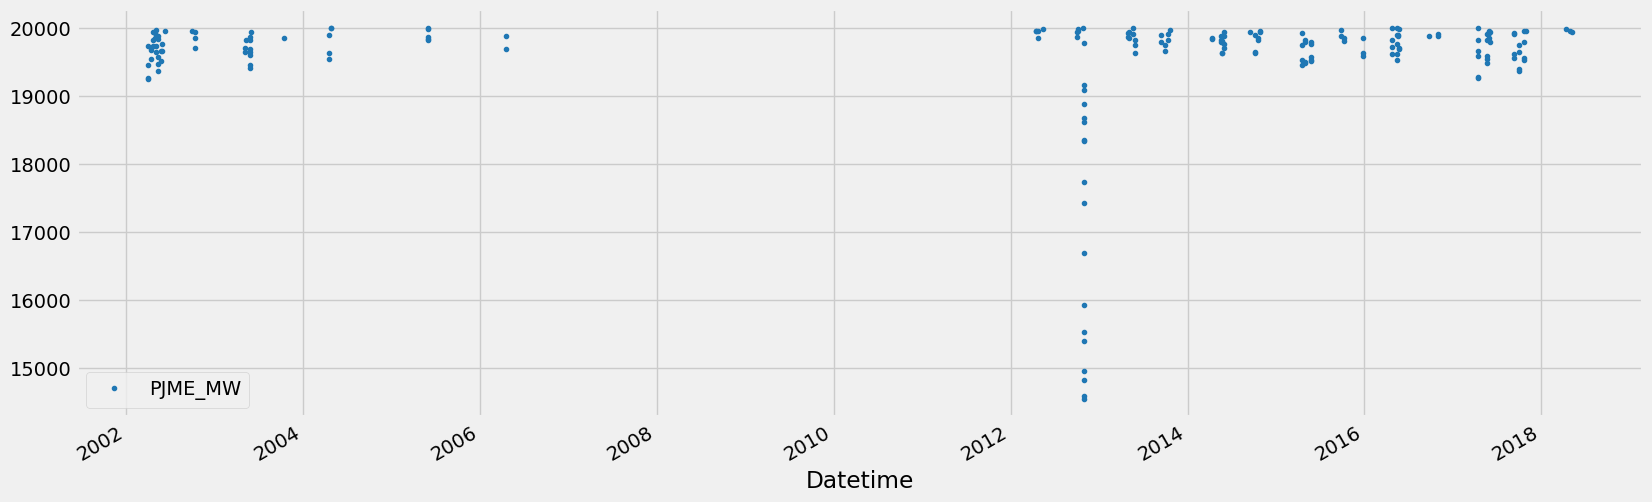

In [9]:
df[df['PJME_MW']<20000].plot(style='.', figsize=(18,6), color=color_pal[0])

In [10]:
df = df[df['PJME_MW']>19000].copy()

In [11]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [12]:
#Stationary check
from statsmodels.tsa.stattools import adfuller

result=adfuller(df['PJME_MW'])
print(f'ADF Statistics: {result[0]}')
print(f'p value {round(result[1],3)}')
print('critical values:')
for key, value in result[4].items():
    print(f'\t{key}: {round(value,3)}')

ADF Statistics: -18.821426012359467
p value 0.0
critical values:
	1%: -3.43
	5%: -2.862
	10%: -2.567


In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

/Users/mingtsung/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


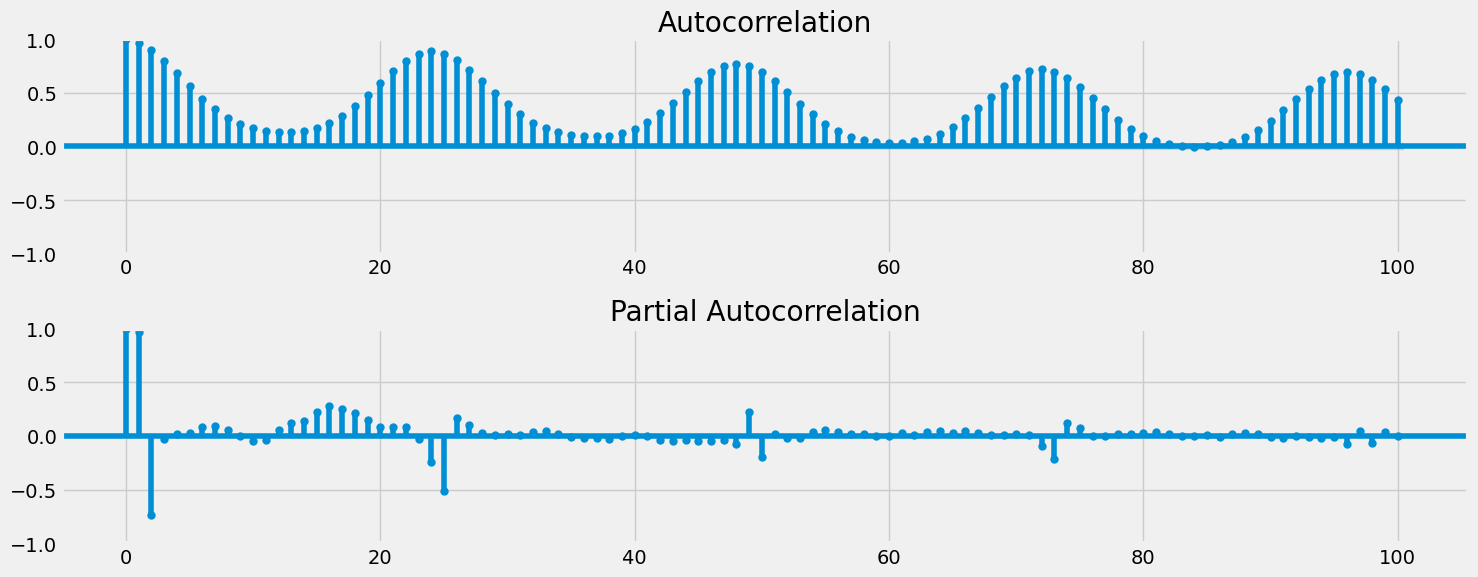

In [19]:
fig, ax = plt.subplots(2,1,figsize=(15,6))
plot_acf(df['PJME_MW'], lags=100, alpha=0.05, ax=ax[0])
plot_pacf(df['PJME_MW'], lags=100, alpha=0.05, ax=ax[1])
fig.tight_layout()
plt.show()

Seasonal cycle for about 24 (24 hour a day)

In [16]:
#train test split
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

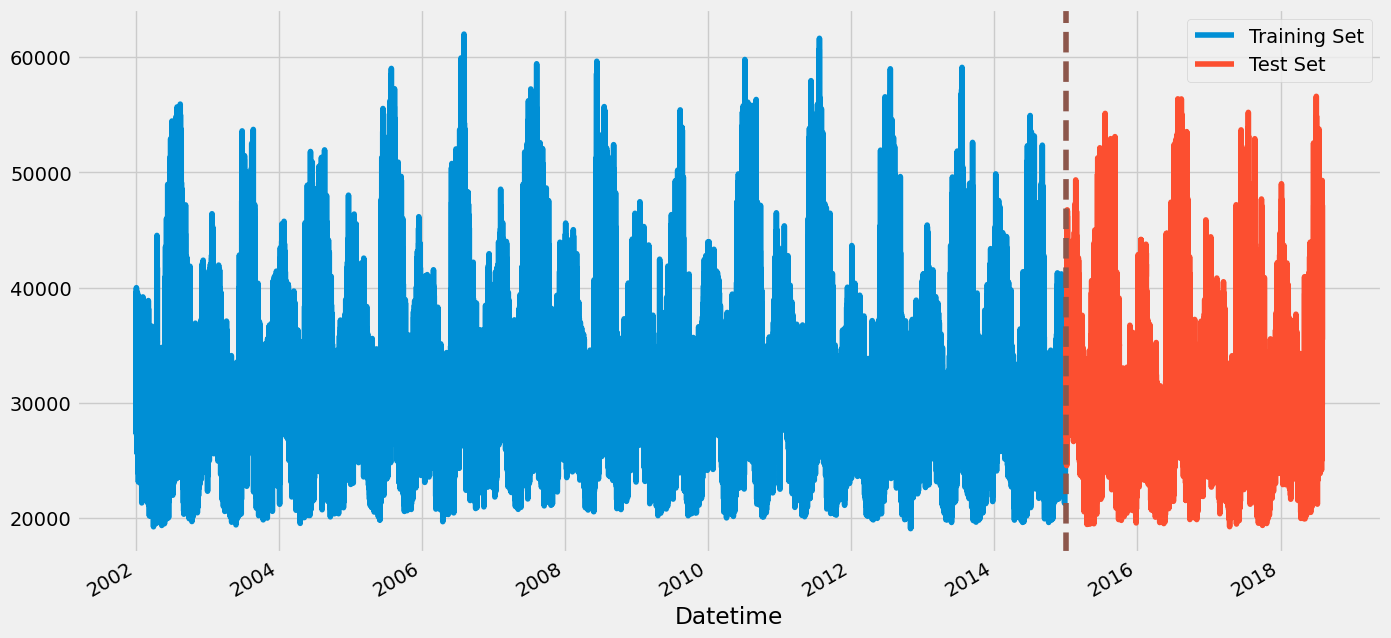

In [17]:
fig, ax = plt.subplots(figsize=(15,8))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('2015-01-01', color=color_pal[5], ls='--')
ax.legend(['Training Set','Test Set'], loc='upper right')
plt.show()

In [21]:
model = sm.tsa.statespace.SARIMAX(df['PJME_MW'], order=(1,1,1), seasonal_order=(1,1,1,24))
results=model.fit(disp=False)

/Users/mingtsung/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mingtsung/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mingtsung/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mingtsung/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13508D+00    |proj g|=  2.43632D-02

At iterate    5    f=  8.01811D+00    |proj g|=  3.34862D-02

At iterate   10    f=  8.01705D+00    |proj g|=  1.67003D-03

At iterate   15    f=  8.01703D+00    |proj g|=  8.94867D-04

At iterate   20    f=  8.01697D+00    |proj g|=  5.84594D-03

At iterate   25    f=  8.01340D+00    |proj g|=  2.76527D-02

At iterate   30    f=  8.00042D+00    |proj g|=  5.63039D-03

At iterate   35    f=  7.99999D+00    |proj g|=  1.11271D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            PJME_MW   No. Observations:               145351
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood            -1162806.271
Date:                            Sat, 07 Jan 2023   AIC                        2325622.541
Time:                                    18:32:35   BIC                        2325671.975
Sample:                                         0   HQIC                       2325637.295
                                         - 145351                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4469      0.008     53.605      0.000       0.431       0.463
ma.L1         -0.1570      0.009    -17.929      0.000      -0.174      -0.140
ar.S.L24       0.4376      0.001    504.714      0.000       0.436       0.439
ma.S.L24      -0.9414      0.001  -1290.971      0.000      -0.943      -0.940
sigma2      5.214e+05    512.076   1018.271      0.000     5.2e+05    5.22e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.68   Jarque-Bera (JB):           9844581.37
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
future = pd.date_range('2018-08-03','2018-08-08', freq='1h')
future_df = pd.DataFrame(index=future)

In [71]:
future_df.tail()

""
2018-08-07 20:00:00
2018-08-07 21:00:00
2018-08-07 22:00:00
2018-08-07 23:00:00
2018-08-08 00:00:00


In [72]:
forcast_value = results.get_forecast(steps=121)

/Users/mingtsung/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [73]:
forcast_value.summary_frame()

PJME_MW,mean,mean_se,mean_ci_lower,mean_ci_upper
145351,38136.344029,722.102654,36721.048833,39551.639225
145352,37548.897513,1178.542554,35238.996553,39858.798474
145353,37214.201895,1561.884727,34152.964081,40275.439708
145354,37264.818526,1891.411380,33557.720342,40971.916710
145355,37775.468214,2180.731803,33501.312419,42049.624008
...,...,...,...,...
145467,44471.198574,20072.884462,5129.067962,83813.329187
145468,43121.781725,20204.024404,3522.621552,82720.941899
145469,41149.947052,20334.318616,1295.414915,81004.479188
145470,39350.877887,20463.783253,-757.400277,79459.156050


In [76]:
future_df['predict'] = list(forcast_value.predicted_mean)

In [78]:
future_df.head()

,predict
2018-08-03 00:00:00,38136.344029
2018-08-03 01:00:00,37548.897513
2018-08-03 02:00:00,37214.201895
2018-08-03 03:00:00,37264.818526
2018-08-03 04:00:00,37775.468214


<AxesSubplot:title={'center':'Future Prediction'}>

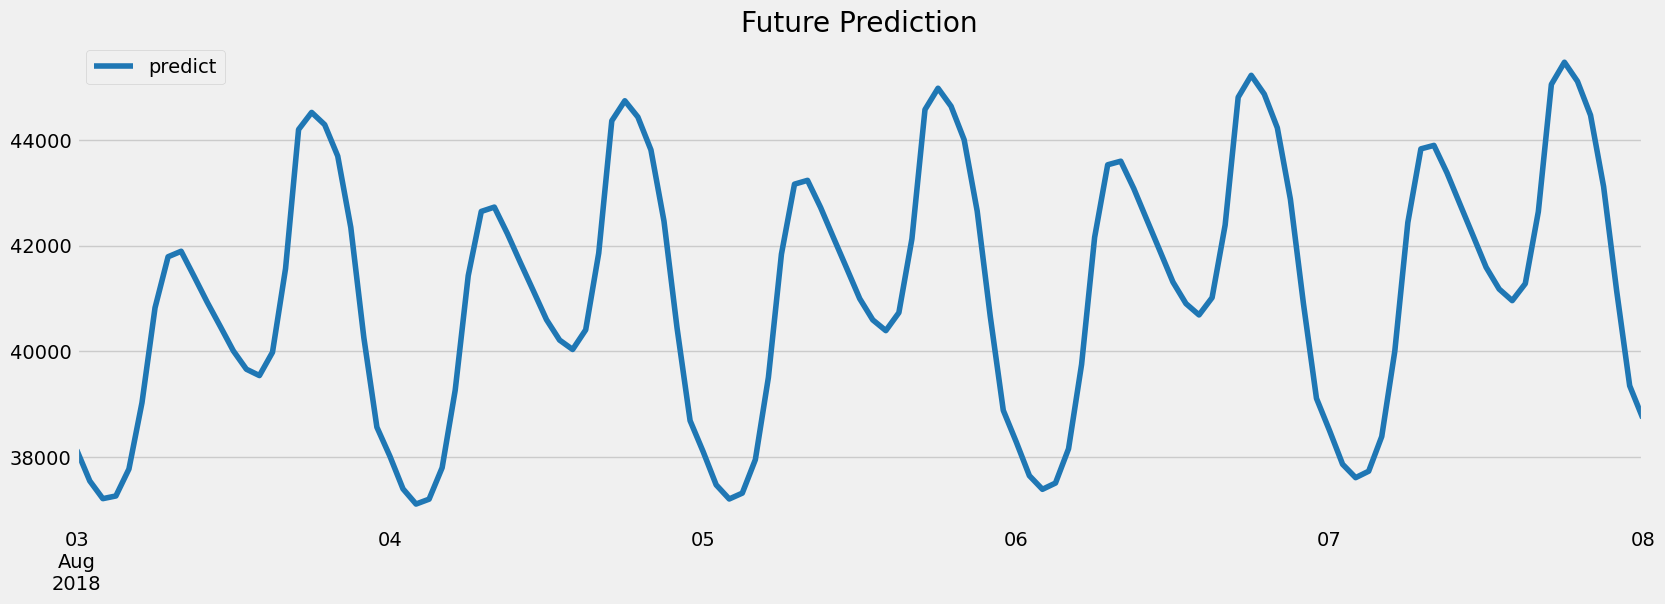

In [79]:
future_df.plot(style='-', figsize=(18,6), color=color_pal[0], title='Future Prediction')